## Projeto Analysis of Diabetes Risk Factor

### Machine Learning.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Carregando o Dataset pré-processado

In [110]:
df_diabetes_indcators = pd.read_csv("..\\datalake\\processing\\diabetes_indcators.csv", index_col=0)

In [111]:
df_diabetes_indcators.head()

,high_blood_preassure,high_cholesterol,body_mass_index,age,physical_activity_in_past_30_days,physical_illness_injury_days,education,income,serious_difficulty_walking,heart_diseaseor_attack,days_of_poor_mental_health,diabetes
0,1,1,40.0,9,0,15,4,3,1,0,18,0
1,0,0,25.0,7,1,0,6,1,0,0,0,0
2,1,1,28.0,9,0,30,4,8,1,0,30,0
3,1,0,27.0,11,1,0,3,6,0,0,0,0
4,1,1,24.0,11,1,0,5,4,0,0,3,0


### Transformação de Features

In [112]:
def map_imc_ranges(x):
    if x < 25:
        return 0
    elif x >= 25 and x <= 30:
        return 1
    else:
        return 2

In [113]:
df_diabetes_indcators['body_mass_index'] = df_diabetes_indcators['body_mass_index'].map(lambda x:map_imc_ranges(x))

In [114]:
def map_age_ranges(x):
    if x < 6:
        return 0
    elif x >= 6 and x <= 7:
        return 1
    elif x >= 8 and x <= 9:
        return 2
    else:
        return 3

In [115]:
df_diabetes_indcators['age'] = df_diabetes_indcators['age'].map(lambda x:map_age_ranges(x))

In [116]:
def map_physical_mental_health_days(x):
    if x < 10:
        return 0
    elif x >= 10 and x <= 20:
        return 1
    else:
        return 2

In [117]:
df_diabetes_indcators['physical_illness_injury_days'] = df_diabetes_indcators['physical_illness_injury_days']\
    .map(lambda x:map_physical_mental_health_days(x))
df_diabetes_indcators['days_of_poor_mental_health'] = df_diabetes_indcators['days_of_poor_mental_health']\
    .map(lambda x:map_physical_mental_health_days(x))

In [118]:
def map_education_scale(x):
    if x < 4:
        return 1
    elif x >= 4 and x <= 5:
        return 2
    else:
        return 3

In [119]:
df_diabetes_indcators['education'] = df_diabetes_indcators['education'].map(lambda x:map_education_scale(x))

In [120]:
def map_income_scale(x):
    if x < 3:
        return 1
    elif x >= 3 and x <= 5:
        return 2
    else:
        return 3

In [121]:
df_diabetes_indcators['income'] = df_diabetes_indcators['income'].map(lambda x:map_income_scale(x))

In [122]:
df_diabetes_indcators.head()

,high_blood_preassure,high_cholesterol,body_mass_index,age,physical_activity_in_past_30_days,physical_illness_injury_days,education,income,serious_difficulty_walking,heart_diseaseor_attack,days_of_poor_mental_health,diabetes
0,1,1,2,2,0,1,2,2,1,0,1,0
1,0,0,1,1,1,0,3,1,0,0,0,0
2,1,1,1,2,0,2,2,3,1,0,2,0
3,1,0,1,3,1,0,1,3,0,0,0,0
4,1,1,0,3,1,0,2,2,0,0,0,0


#### Separando os conjuntos de dados.

In [123]:
target_name = 'diabetes'
X = df_diabetes_indcators.drop('diabetes', axis=1)
y = df_diabetes_indcators[target_name]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y
       ,test_size = 0.2
       ,random_state = 123
       ,stratify = y
)

#### Treinando o algoritmo de arvore de decisão.

In [125]:
from sklearn.tree import DecisionTreeClassifier

In [126]:
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train,y_train)

In [127]:
importances = decision_tree.feature_importances_
feat_names = df_diabetes_indcators.drop(['diabetes'],axis=1).columns

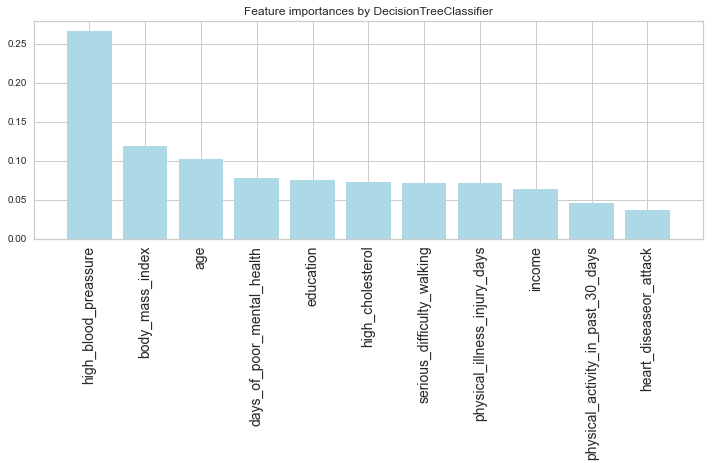

In [128]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,4))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

#### Filtrando apenas os atributos relevantes.

In [130]:
X = df_diabetes_indcators.drop("diabetes", axis=1)

#### Realizando balanceamento de classes.

In [132]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [133]:
nm = NearMiss(sampling_strategy=0.40)

In [134]:
x_nm, y_nm = nm.fit_resample(X, y)

In [135]:
smote = SMOTE(sampling_strategy=0.60, random_state=33)

In [136]:
x_smote, y_smote = smote.fit_resample(x_nm, y_nm)

#### Separando os conjuntos de dados.

In [137]:
y_smote.value_counts()

0    87742
1    52645
Name: diabetes, dtype: int64

In [138]:
scaler = MinMaxScaler()

In [139]:
X = scaler.fit_transform(x_smote)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y_smote
       ,test_size = 0.2
       ,random_state = 123
)

#### Função do modelo de base.

In [141]:
def base_rate_model(X) :
    return np.zeros(X.shape[0])

#### Importando métodos de métrica de avaliação.

In [142]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

In [143]:
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

#### Análise do modelo de baseline

In [144]:
y_predict = base_rate_model(X_test)

In [145]:
roc_classification_report_results("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.62      1.00      0.77     17507
           1       0.00      0.00      0.00     10571

    accuracy                           0.62     28078
   macro avg       0.31      0.50      0.38     28078
weighted avg       0.39      0.62      0.48     28078



### Modelo de Árvore de Decisão

#### Instânciando o algoritmo.

In [146]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

#### Realizando o treinamento.

In [147]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Calculando as predições.

In [148]:
y_predict = decision_tree.predict(X_test)

#### Avaliando o resultado.

In [149]:
roc_classification_report_results("Decision Tree", y_test, y_predict)


Decision Tree AUC = 0.7133050019312789

              precision    recall  f1-score   support

           0       0.77      0.87      0.81     17507
           1       0.72      0.56      0.63     10571

    accuracy                           0.75     28078
   macro avg       0.74      0.71      0.72     28078
weighted avg       0.75      0.75      0.74     28078



### Modelo de Arvore Aleatória (Random Forest)

#### Instânciando o algoritmo.

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
random_forest = RandomForestClassifier()

#### Realizando o treinamento.

In [590]:
random_forest.fit(X_train,y_train)

RandomForestClassifier()

#### Calculando as predições.

In [591]:
y_predict = random_forest.predict(X_test)

#### Avaliando o resultado.

In [592]:
roc_classification_report_results("Random Forest", y_test, y_predict)


Random Forest AUC = 0.699644566136679

              precision    recall  f1-score   support

           0       0.76      0.82      0.79     17507
           1       0.66      0.58      0.62     10571

    accuracy                           0.73     28078
   macro avg       0.71      0.70      0.70     28078
weighted avg       0.72      0.73      0.73     28078



### Pycaret

In [ ]:
pip install pycaret

#### Importando os métodos.

In [47]:
from pycaret.classification import *

#### Definindo o Setup.

In [160]:
x_smote['diabetes']=y_smote
defined_setup = setup(x_smote
          ,target = "diabetes"
          ,normalize = True
          ,normalize_method = "minmax"
          ,data_split_stratify = True
          ,fix_imbalance = True,
          fix_imbalance_method = SMOTE(sampling_strategy=0.8),
          feature_selection = True,
          feature_selection_threshold = 0.8
         )


,Description,Value
0,session_id,3722
1,Target,diabetes
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(140387, 12)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


#### Comparando diferentes modelos.

In [153]:
best_model = compare_models(fold = 5,sort = 'AUC', include = ['lightgbm', 'xgboost'], probability_threshold = 0.45)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7467,0.8286,0.7411,0.6402,0.6870,0.4762,0.4798,7.0860
lightgbm,Light Gradient Boosting Machine,0.7484,0.8281,0.7406,0.6427,0.6882,0.4790,0.4824,4.8900


#### Criando o modelo.

In [161]:
light_gbm = create_model('lightgbm', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7562,0.8295,0.7075,0.6643,0.6852,0.4866,0.4873
1,0.7530,0.8262,0.6991,0.6614,0.6797,0.4789,0.4794
2,0.7524,0.8253,0.7069,0.6582,0.6817,0.4795,0.4803
3,0.7521,0.8268,0.6958,0.6609,0.6779,0.4766,0.4770
4,0.7534,0.8270,0.6972,0.6628,0.6796,0.4794,0.4798
Mean,0.7534,0.8269,0.7013,0.6615,0.6808,0.4802,0.4808
SD,0.0015,0.0014,0.0049,0.0021,0.0025,0.0034,0.0034


#### Realizando o tunning do modelo.

In [193]:
tuned_light_gbm = tune_model(light_gbm,
                             fold = 5,
                             custom_grid = {
                                          "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                                         ,"n_estimators":[x for x in range(100, 1100, 100)]
                                         ,"num_leaves":[2, 4, 8]
                                         ,"max_depth":[2, 4, 8, 16]
                                         },
                             optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7579,0.8302,0.7011,0.6690,0.6847,0.4883,0.4887
1,0.7553,0.8280,0.6900,0.6682,0.6789,0.4813,0.4814
2,0.7543,0.8257,0.6923,0.6658,0.6788,0.4800,0.4802
3,0.7545,0.8275,0.6875,0.6677,0.6775,0.4794,0.4795
4,0.7558,0.8279,0.6899,0.6692,0.6794,0.4822,0.4824
Mean,0.7555,0.8279,0.6921,0.6680,0.6798,0.4822,0.4824
SD,0.0013,0.0014,0.0047,0.0012,0.0025,0.0032,0.0033


#### Finalizando o modelo.

In [194]:
final_model = finalize_model(tuned_light_gbm)

In [198]:
save_model(final_model,'..\\datalake\\curated\\model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='diabetes',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_str...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=8,
                                 min_child_samples=20, 

#### Transferindo os arquivos para o Data Lake.

In [197]:
x_smote.to_csv("..\\datalake\\curated\\dataset.csv", index=False)